<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Module-import" data-toc-modified-id="Module-import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Module import</a></span></li><li><span><a href="#데이터-확인" data-toc-modified-id="데이터-확인-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>데이터 확인</a></span></li><li><span><a href="#전처리" data-toc-modified-id="전처리-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>전처리</a></span></li><li><span><a href="#데이터정제" data-toc-modified-id="데이터정제-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>데이터정제</a></span></li><li><span><a href="#Tokenizing" data-toc-modified-id="Tokenizing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tokenizing</a></span></li><li><span><a href="#데이터-분리" data-toc-modified-id="데이터-분리-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>데이터 분리</a></span><ul class="toc-item"><li><span><a href="#src_input,-tgt_input-생성" data-toc-modified-id="src_input,-tgt_input-생성-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>src_input, tgt_input 생성</a></span></li><li><span><a href="#training/test-set-분리" data-toc-modified-id="training/test-set-분리-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>training/test set 분리</a></span></li></ul></li><li><span><a href="#데이터셋-객체생성" data-toc-modified-id="데이터셋-객체생성-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>데이터셋 객체생성</a></span></li><li><span><a href="#학습시키기" data-toc-modified-id="학습시키기-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>학습시키기</a></span></li><li><span><a href="#손실값-시각화" data-toc-modified-id="손실값-시각화-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>손실값 시각화</a></span></li><li><span><a href="#가사생성" data-toc-modified-id="가사생성-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>가사생성</a></span><ul class="toc-item"><li><span><a href="#실행" data-toc-modified-id="실행-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>실행</a></span></li></ul></li><li><span><a href="#회고" data-toc-modified-id="회고-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>회고</a></span></li></ul></div>

# Module import

In [14]:
import glob
import os, re 
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('homepath')+'/aiffel/lyricist/data/lyrics/*' 
'''os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. 
   txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장
'''
txt_list = glob.glob(txt_file_path) 
'''txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당
'''
raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 180847
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


# 데이터 확인

In [15]:
# enumerate() 함수를 이용하여 raw_corpus list 내에 저장된 문장과 그 문장의 인덱스를 반환 (인덱스, 문장 순)
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다. 문장을 line별로 가져움을 상기!!

    if idx > 10: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Looking for some education
Made my way into the night
All that bullshit conversation
Baby, can't you read the signs? I won't bore you with the details, baby
I don't even wanna waste your time
Let's just say that maybe
You could help me ease my mind
I ain't Mr. Right But if you're looking for fast love
If that's love in your eyes
It's more than enough
Had some bad love


# 전처리

In [16]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence



# 데이터정제

In [17]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:

    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    #if len(sentence) > 15:  continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> looking for some education <end>',
 '<start> made my way into the night <end>',
 '<start> all that bullshit conversation <end>',
 '<start> baby , can t you read the signs ? i won t bore you with the details , baby <end>',
 '<start> i don t even wanna waste your time <end>',
 '<start> let s just say that maybe <end>',
 '<start> you could help me ease my mind <end>',
 '<start> i ain t mr . right but if you re looking for fast love <end>',
 '<start> if that s love in your eyes <end>',
 '<start> it s more than enough <end>']

# Tokenizing

In [18]:
# 토큰화는 문장을 숫자형태로 변환하는 개념. 텐서플로우의 Tokenizer와 pad_sequences를 사용

def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer
    # 우리는 이미 문장을 정제했으니 filters가 필요없음
    # 14000단어에 포함되지 못한 단어는 '<unk>'로 
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=14000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   

    # max tocken len = 15로 정함
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 311  28 ...   0   0   0]
 [  2 219  13 ...   0   0   0]
 [  2  24  17 ...   0   0   0]
 ...
 [  2  30  21 ...   1   3   0]
 [  2 336  21 ...   3   0   0]
 [  2  42 131 ...   0   0   0]] <keras.preprocessing.text.Tokenizer object at 0x000001F5427CDA60>


In [19]:
tensor.shape

(169526, 15)

# 데이터 분리

## src_input, tgt_input 생성

In [20]:
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:] #<start = 0번째 index>    

print(src_input[0])
print(src_input.shape)
print(tgt_input[0])
print(tgt_input.shape)

[   2  311   28   98 4740    3    0    0    0    0    0    0    0    0]
(169526, 14)
[ 311   28   98 4740    3    0    0    0    0    0    0    0    0    0]
(169526, 14)


## training/test set 분리

In [21]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=15)

print(enc_train.shape, enc_val.shape)
print(dec_train.shape, dec_val.shape)

(135620, 14) (33906, 14)
(135620, 14) (33906, 14)


# 데이터셋 객체생성

In [22]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1   
'''tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
  tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
  tokenize() 함수에서 num_words를 12000개로 선언했기 때문에, tokenizer.num_words의 값은 000

  뒤섞기,이 함수의 parameter 중 하나는 buffer_size, dataset이 올바른 방법으로 실제로 섞이지 않기 때문에
  Training성능이 낮게될 것임, 따라서 trainig을 시작할 때, dataset은 BUFFER_SIZE 만큼 가져오고 
  다음 램덤하게 BATCH_SIZE만큼 PICK할 것임 '''
    
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset


<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

# 학습시키기

In [25]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 256 # 벡터의 차원수
hidden_size = 1024

#언어 모델(Languagel Model)이란 단어 시퀀스(문장)에 확률을 할당하는 모델
#어떤 문장들이 있을 때, 기계가 이 문장은 적절해! 이 문장은 말이 안 돼! 라고 
#사람처럼 정확히 판단할 수 있다면, 기계이 자연어 처리의 성능이 뛰어나다고 말할 수 있습니다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 
# tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문



In [26]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
for src_sample, tgt_sample in dataset.take(1): break

model(src_sample)

<tf.Tensor: shape=(256, 14, 14001), dtype=float32, numpy=
array([[[ 2.39055938e-04, -7.00694218e-05,  1.04391365e-05, ...,
         -5.17294757e-06,  1.58298557e-04, -2.08667298e-05],
        [ 1.72917455e-04, -1.86723133e-04,  9.60677426e-06, ...,
          3.20626932e-05,  2.57108419e-04, -1.76653703e-05],
        [ 8.24528106e-05, -2.33285900e-05,  1.78741771e-04, ...,
         -3.39577309e-06,  2.67646508e-04, -7.79754919e-05],
        ...,
        [-3.38219543e-05, -1.78667076e-03,  1.04215508e-03, ...,
          1.61900336e-03, -1.15865532e-06,  1.96250563e-04],
        [-1.30233544e-04, -2.11479585e-03,  1.04573893e-03, ...,
          1.97328161e-03, -6.37912817e-05,  3.72149196e-04],
        [-2.58939603e-04, -2.42630648e-03,  1.02163677e-03, ...,
          2.31066043e-03, -1.08652850e-04,  4.99248970e-04]],

       [[ 2.39055938e-04, -7.00694218e-05,  1.04391365e-05, ...,
         -5.17294757e-06,  1.58298557e-04, -2.08667298e-05],
        [ 2.13907653e-04,  6.45014006e-05,  1

In [1]:
model.summary()

NameError: name 'model' is not defined

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1) 
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계
model.compile(loss=loss, optimizer=optimizer,  metrics=['accuracy']) # 손실함수와 훈련과정을 설정
history = model.fit(dataset,
          epochs=1,
          validation_data=val_dataset,
          verbose=1)

529/529 [==============================] - 1827s 3s/step - loss: 5.6675 - accuracy: 0.4233 - val_loss: 4.4719 - val_accuracy: 0.4356


In [29]:
dir(history)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_implements_predict_batch_hooks',
 '_implements_test_batch_hooks',
 '_implements_train_batch_hooks',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_supports_tf_logs',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

In [30]:
history.epoch

[0]

In [31]:
history.history

{'loss': [5.667545318603516],
 'accuracy': [0.4233476221561432],
 'val_loss': [4.471937656402588],
 'val_accuracy': [0.43560606241226196]}

# 손실값 시각화

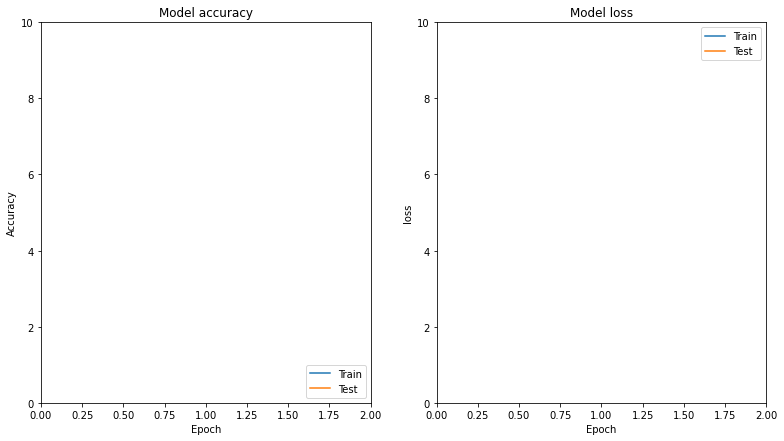

In [36]:
import matplotlib.pyplot as plt

# 훈련 과정 시각화 (정확도)
fig = plt.figure(figsize=(13, 7))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0, 2)
plt.ylim(0, 10)
plt.legend(['Train', 'Test' ], loc='lower right')
#plt.show()

# 훈련 과정 시각화 (손실)
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.xlim(0, 2)
plt.ylim(0, 10)
plt.legend(['Train', 'Test' ], loc='upper right')
plt.show()



# 가사생성

In [34]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성
        # 1 입력받은 문장의 텐서를 입력합니다. 
        predict = model(test_tensor) # 
        # 2 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 우리 모델이 를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

## 실행

In [35]:
generate_text(model, tokenizer, init_sentence=" <start> i ")

'<start> i ve <end> '

# 회고
    Case1) local jupyter 활용
        embedding_size = 256 
        hidden_size = 1024
        epochs=1 <컴퓨터가 터질 것 같아 안전상 여기에서 멈춤, safety first!>
        Total params: 31,574,961
        val_loss: 4.471937656402588 
        generate_text()실행시 창의성이 너~~무 낮았다.  i 뒤에 ve 이라니..
        embedding_size 및 hidden_size를 늘려 추상화를 늘리고 학습회수도 조금 더 조정해야 
        창의성이 발휘 될 수 있을 것 같습니다. 

    
    Case2) LMS에서 동일한 코드를 적용 후 결과
        embedding_size = 2048 
        hidden_size = 2048
        epochs=10
        val_loss: 2.2621097564697266
        Total params: 124,487,345
        입력문자: '<start> feel
        생성문장: '<start> feel like i m livin at the bottom of a grave <end> '
        입력문자: '<start> oh
        생성문자: '<start> ohh , i , i feel like going on , yes i do <end> '
        입력문자: '<start> sky
        생성문자: '<start> sky is the limit and you know that you keep on <end> '